# Web Scraping

Last time, we looked at REST API's as a source of data. You can get lots of very high quality data this way.

Some data is available online, but not through an API. When this is the case, some times you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with.

We'll be scraping data about used cars in Charlottesville from Craigslist. This will give us a chance to put those wrangling, EDA, and visualization skills to work.

We'll use the `requests` package, as we did with API's, but will be getting the kinds of web pages you see everyday. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville.

## 1. Pick something else on Craigslist: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of EDA you'd do with it. I look at used cars below.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/white-hall-va/cta?lat=38.088&lon=-78.7013&search_distance=8#search=1~gallery~0~0'
raw = requests.get(url,headers=header) # Get page

I tried with boats at first but there were way too many boats in Miami and it was hard to get the brands, I later tried with boat_types but just saw my mistake and it was that I was calling for brands while doing types. Because of this I chose cars in Crozet (added Mercedez Benz)

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tages, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

## 2. Get your search results of interest and extract data from them, using code similar to what's below.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [8]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

For each listing, we'll use the `.find` method to search within the listing record for specific information. To get the information we want, we can then use `.get_text()`.

In the code below, two more things happen.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [11]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti', 'mercedez']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})

## 3. Wrangle your data, do some EDA, and make some plots. Try to find some interesting relationships or stories to tell about your data.


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [12]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(25, 6)


,title,price,year,link,brand,age
0,sequoia 2005,2000,2005.0,https://charlottesville.craigslist.org/cto/d/c...,missing,20.0
1,2005 toyota tundra sr5 crew cab,7000,2005.0,https://charlottesville.craigslist.org/cto/d/c...,toyota,20.0
2,mercedes benz 2016 gle 300d diesel suv,25000,2016.0,https://charlottesville.craigslist.org/cto/d/c...,missing,9.0
3,used 2009 hyundai santa fe,3000,2009.0,https://charlottesville.craigslist.org/cto/d/c...,missing,16.0
4,2021 toyota tundra 1794 crew max,49900,2021.0,https://charlottesville.craigslist.org/cto/d/c...,toyota,4.0


With the data in and wrangled, we can now do EDA:

count       25.000000
mean      9311.600000
std      11106.500443
min        250.000000
25%       2899.000000
50%       6000.000000
75%      11665.000000
max      49900.000000
Name: price, dtype: float64


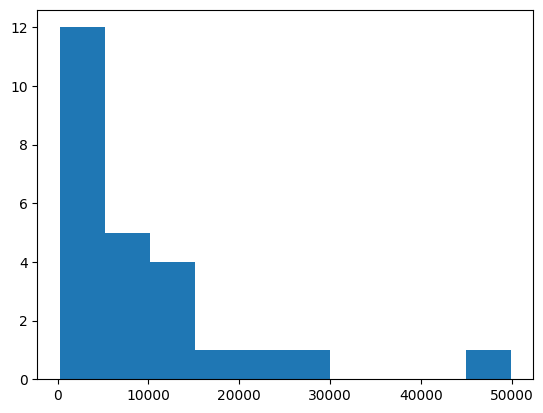

count    16.000000
mean     17.687500
std       8.537906
min       4.000000
25%      12.000000
50%      18.000000
75%      20.250000
max      36.000000
Name: age, dtype: float64


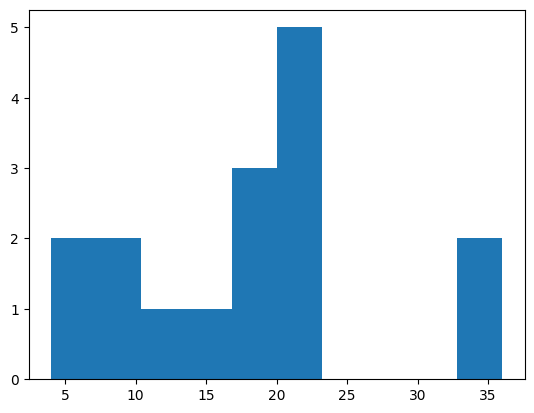

In [13]:
# EDA for price and age:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [16]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
          count          mean           std      min       25%      50%   
brand                                                                     
acura       1.0   3500.000000           NaN   3500.0   3500.00   3500.0   
audi        1.0  11665.000000           NaN  11665.0  11665.00  11665.0   
chevrolet   1.0  17500.000000           NaN  17500.0  17500.00  17500.0   
dodge       1.0   6000.000000           NaN   6000.0   6000.00   6000.0   
ford        3.0   4266.666667   3709.896674   1000.0   2250.00   3500.0   
honda       2.0   1949.500000   1342.795777   1000.0   1474.75   1949.5   
missing    11.0   7220.545455   7872.206455    250.0   1225.00   3000.0   
tesla       1.0  26000.000000           NaN  26000.0  26000.00  26000.0   
toyota      4.0  18000.000000  21453.981759   4100.0   6275.00   9000.0   

                              
                75%      max  
brand                         
acura       3500.00   3500.0  
audi       11665.00  11665.0  
chevrolet  17500.00  17500.0  
dodge       6000.00   6000.0  
ford        5900.00   8300.0  
honda       2424.25   2899.0  
missing    11219.00  25000.0  
tesla      26000.00  26000.0  
toyota     20725.00  49900.0

In [18]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                 
          count   mean       std   min    25%   50%    75%   max
brand                                                           
acura       1.0  17.00       NaN  17.0  17.00  17.0  17.00  17.0
audi        0.0    NaN       NaN   NaN    NaN   NaN    NaN   NaN
chevrolet   1.0  36.00       NaN  36.0  36.00  36.0  36.00  36.0
dodge       0.0    NaN       NaN   NaN    NaN   NaN    NaN   NaN
ford        3.0  17.00  3.605551  13.0  15.50  18.0  19.00  20.0
honda       2.0  27.50  7.778175  22.0  24.75  27.5  30.25  33.0
missing     4.0  16.50  5.446712   9.0  14.25  18.0  20.25  21.0
tesla       1.0   9.00       NaN   9.0   9.00   9.0   9.00   9.0
toyota      4.0  12.25  7.932003   4.0   6.25  12.5  18.50  20.0

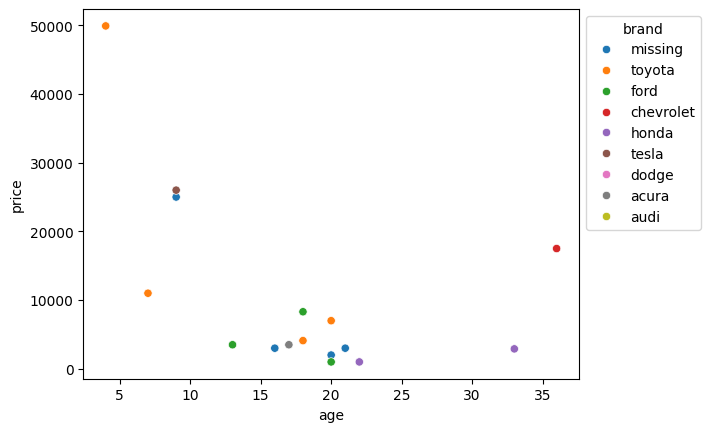

In [19]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   1.928433 -0.406042
log_age    -0.406042  0.322254
           log_price   log_age
log_price   1.000000 -0.618117
log_age    -0.618117  1.000000


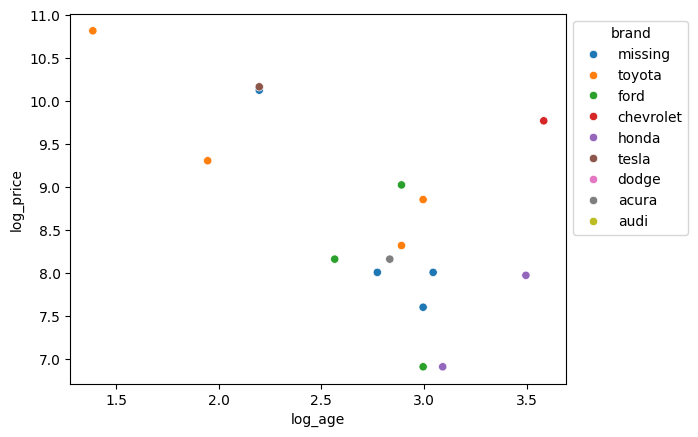

In [20]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

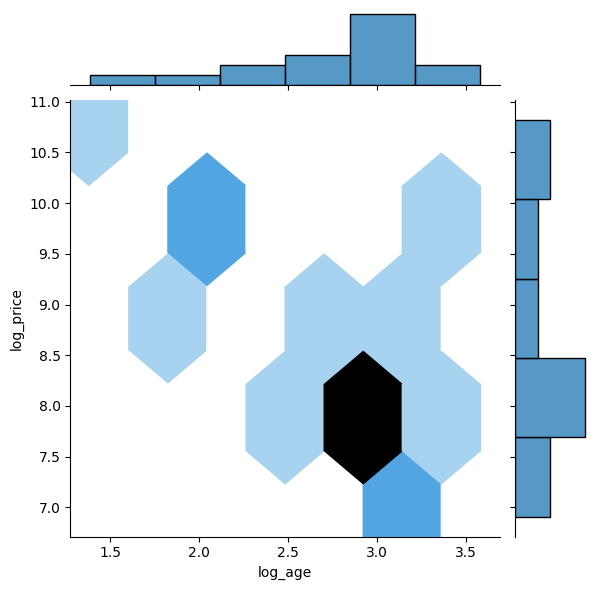

In [21]:
sns.jointplot(data=df, x='log_age', y='log_price',kind='hex')

## 4. (Optional) From your search results, crawl to the links and extract more information about every listing in your original dataframe. Wrangle and do some EDA.

The final thing we want to do is go from scraping a single page to crawling around.

The idea here is that every web page is connected to some other page. By extracting links as we move from page to page, we can create a web crawler that wanders around for us, gathering information of interest.

In this case, we want to use the search results to then visit each individual page for each listing. Since we saved the links to the web pages in the previous scrape, we can now simply for-loop over that column in the dataframe, visiting the page listing for each of the cars in the search results:

In [22]:
import time # Time delays
import random # Random numbers

links = df['link']
data = []
for link in links: # about 3 minutes
    time.sleep(random.randint(1, 3)) # Random delays
    raw = requests.get(link,headers=header) # Get page
    bsObj = soup(raw.content,'html.parser') # Parse the html
    #
    try:
        year_post = bsObj.find(class_='attr important').find(class_ = 'valu year').get_text()
    except:
        year_post = np.nan
    #
    try:
        condition = bsObj.find(class_='attr condition').find(href=True).get_text()
    except:
        condition = 'missing'
    #
    try:
        cylinders = bsObj.find(class_='attr auto_cylinders').find(class_ = 'valu').get_text()
        cylinders = cylinders.replace('\n','')
    except:
        cylinders = 'missing'
    #
    try:
        drivetrain = bsObj.find(class_='attr auto_drivetrain').find(href=True).get_text()
    except:
        drivetrain = 'missing'
    #
    try:
        fuel = bsObj.find(class_='attr auto_fuel_type').find(href = True).get_text()
    except:
        fuel = 'missing'
    #
    try:
        miles = bsObj.find(class_='attr auto_miles').find(class_ = 'valu').get_text()
    except:
        miles = np.nan
    #
    try:
        color = bsObj.find(class_='attr auto_paint').find(href=True).get_text()
    except:
        color='missing'
    #
    try:
        title = bsObj.find(class_='attr auto_title_status').find(href=True).get_text()
    except:
        title='missing'
    #
    try:
        transmission = bsObj.find(class_='attr auto_transmission').find(href=True).get_text()
    except:
        transmission = 'missing'
    #
    try:
        bodytype = bsObj.find(class_='attr auto_bodytype').find(href=True).get_text()
    except:
        bodytype = 'missing'
    #
    text = bsObj.find(id='postingbody').get_text()
    text = text.replace('\n','')
    text = text.replace('QR Code Link to This Post','')
    record = {'title':title,
              'year_post':year_post,
              'condition':condition,
              'cylinders':cylinders,
              'drivetrain':drivetrain,
              'fuel':fuel,
              'miles':miles,
              'color':color,
              'title':'title',
              'transmission':transmission,
              'bodytype':bodytype,
              'text':text,}
    data.append(record)

What are the new features here?

First, we don't want to overwhelm the servers, so we put a small delay between each request of a listing, `time.sleep(random.randint(1, 3))`. This waits a random amount of time between 1 and 3 seconds to avoid overwhelming their server.

Second, we use the try/except block. This is a useful control structure in general, but especially for web scraping. Python tries the statements under `try:`, and if it fails, executes the steps under `except:`. This can happen, in this case, with missing data, which crashes the crawler. Instead, we put our missing codes into our dataframe right away.

Third, we used `.find().find().get_text()` to find the data we're looking for. In general, the structure of mark-up langauges like HTML and XML makes it possible to "drill down" into their entries and extract the information of interest. This exploitation of mark-up languages could be the subject of a whole course on procuring data from the web.

With the data scraped, we can make a new dataframe, combine it with the old one using `pd.concat`, and do some wrangling to clean the data up:

In [23]:
new_df = pd.DataFrame.from_dict(data)
new_df.head()

df = pd.concat([df,new_df],axis=1) # combine data frames
df.head()

df.to_csv('craiglist_cville_cars_long.csv')

,title,price,year,link,brand,age,log_price,log_age,title,year_post,...,year_post,condition,cylinders,drivetrain,fuel,miles,color,transmission,bodytype,text
0,2017 nissan sentra sr turbo cvt,14000,2017.0,https://charlottesville.craigslist.org/cto/d/c...,missing,8.0,9.546813,2.079442,title,2017,...,2017,excellent,4 cylinders,missing,gas,"95,000",grey,automatic,sedan,This 2017 Nissan Sentra offers a unique blend ...
1,1997 bmw 328i convertible,4600,1997.0,https://charlottesville.craigslist.org/cto/d/c...,bmw,28.0,8.433812,3.332205,title,1997,...,1997,excellent,6 cylinders,rwd,gas,"161,645",black,automatic,convertible,Clean title in hand - Lots of pictures!-Extrem...
2,1974 dodge stepside 426 hemi,10500,1974.0,https://charlottesville.craigslist.org/cto/d/l...,dodge,51.0,9.259131,3.931826,title,1974,...,1974,excellent,8 cylinders,rwd,gas,"68,000",yellow,automatic,truck,Mopar Guys!!!! Must see this super rare Mopar...
3,"2013 lexus rx350 only 61,500 miles",18900,2013.0,https://charlottesville.craigslist.org/cto/d/m...,lexus,12.0,9.846917,2.484907,title,2013,...,2013,excellent,6 cylinders,4wd,gas,"61,500",white,automatic,SUV,"One owner 2013 Lexus RX350. Driven by my wife,..."
4,sequoia 2005,2000,2005.0,https://charlottesville.craigslist.org/cto/d/c...,missing,20.0,7.600902,2.995732,title,2005,...,2005,good,8 cylinders,4wd,gas,"240,000",black,automatic,missing,"240k highway miles, Runs well, cold ac. Only i..."
